**What is the differences between RNN & LSTM?**

Before I tell you what is LSTM let me tell you about the biggest problem with RNNs. So far everything looks good about RNNs until we train it via back-propagation. As the gradient of our training samples gets propagated backward through our network, it gets weaker and weaker, by the time it gets to those neurons that represent older data points in our time-series it has no juice to adjust them properly. This problem is called Vanishing Gradient. A LSTM cell is a type of RNN which stores important information about the past and forgets the unimportant pieces. In this way, when gradient back-propagates, it won’t be consumed by unnecessary information.

<a href="https://ibb.co/rv1GT5D"><img src="https://i.ibb.co/fQPYBrj/rnn-lstm.png" alt="rnn-lstm" border="0"></a>

*We will use our 50 data to predict 51th data. Also I will take first 200000 data*

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory
import warnings
warnings.filterwarnings("ignore")


import os
print(os.listdir("../input"))

# Any results you write to the current directory are saved as output.

['coinbaseUSD_1-min_data_2014-12-01_to_2019-01-09.csv', 'bitstampUSD_1-min_data_2012-01-01_to_2019-03-13.csv']


In [2]:
bit_data=pd.read_csv("../input/bitstampUSD_1-min_data_2012-01-01_to_2019-03-13.csv")
bit_data["date"]=pd.to_datetime(bit_data["Timestamp"],unit="s").dt.date
group=bit_data.groupby("date")
data=group["Close"].mean()

What I did here? I added a colum which is "date" and I converted "Timestamp" columns to date form.

In [3]:
data.shape

(2627,)

In [4]:
data.isnull().sum()

0

In [5]:
data.head()

date
2011-12-31    4.482500
2012-01-01    4.806667
2012-01-02    5.000000
2012-01-03    5.252500
2012-01-04    5.223333
Name: Close, dtype: float64

The goal is making a prediction of daily Close data. So we will predict "close" values of bitcoin data

**First I will use RNN to predict our data**

I am separating last 50 rows as the test data.

In [6]:
close_train=data.iloc[:len(data)-50]
close_test=data.iloc[len(close_train):]

Here I will set our values between 0-1 in order to avoid domination of high values.

In [7]:
#feature scalling (set values between 0-1)
close_train=np.array(close_train)
close_train=close_train.reshape(close_train.shape[0],1)
from sklearn.preprocessing import MinMaxScaler
scaler=MinMaxScaler(feature_range=(0,1))
close_scaled=scaler.fit_transform(close_train)

Let's choose each 50 data as x-train and 51th as y-train

In [8]:
timestep=50
x_train=[]
y_train=[]

for i in range(timestep,close_scaled.shape[0]):
    x_train.append(close_scaled[i-timestep:i,0])
    y_train.append(close_scaled[i,0])

x_train,y_train=np.array(x_train),np.array(y_train)
x_train=x_train.reshape(x_train.shape[0],x_train.shape[1],1) #reshaped for RNN
print("x_train shape= ",x_train.shape)
print("y_train shape= ",y_train.shape)

x_train shape=  (2527, 50, 1)
y_train shape=  (2527,)


Time to prepare and run our RNN method

In [9]:
from keras.models import Sequential
from keras.layers import Dense, SimpleRNN, Dropout,Flatten

regressor=Sequential()
#first RNN layer
regressor.add(SimpleRNN(128,activation="relu",return_sequences=True,input_shape=(x_train.shape[1],1)))
regressor.add(Dropout(0.25))
#second RNN layer
regressor.add(SimpleRNN(256,activation="relu",return_sequences=True))
regressor.add(Dropout(0.25))
#third RNN layer
regressor.add(SimpleRNN(512,activation="relu",return_sequences=True))
regressor.add(Dropout(0.35))
#fourth RNN layer
regressor.add(SimpleRNN(256,activation="relu",return_sequences=True))
regressor.add(Dropout(0.25))
#fifth RNN layer
regressor.add(SimpleRNN(128,activation="relu",return_sequences=True))
regressor.add(Dropout(0.25))
#convert the matrix to 1-line
regressor.add(Flatten())
#output layer
regressor.add(Dense(1))

regressor.compile(optimizer="adam",loss="mean_squared_error")
regressor.fit(x_train,y_train,epochs=100,batch_size=64)

Using TensorFlow backend.


Epoch 1/100
2527/2527 [==============================] - 9s 4ms/step - loss: 0.0080
Epoch 2/100
2527/2527 [==============================] - 5s 2ms/step - loss: 0.0022
Epoch 3/100
2527/2527 [==============================] - 5s 2ms/step - loss: 0.0017
Epoch 4/100
2527/2527 [==============================] - 5s 2ms/step - loss: 0.0014
Epoch 5/100
2527/2527 [==============================] - 5s 2ms/step - loss: 0.0019
Epoch 6/100
2527/2527 [==============================] - 5s 2ms/step - loss: 0.0012
Epoch 7/100
2527/2527 [==============================] - 5s 2ms/step - loss: 8.1828e-04
Epoch 8/100
2527/2527 [==============================] - 5s 2ms/step - loss: 9.0356e-04
Epoch 9/100
2527/2527 [==============================] - 5s 2ms/step - loss: 0.0010
Epoch 10/100
2527/2527 [==============================] - 5s 2ms/step - loss: 0.0015
Epoch 11/100
2527/2527 [==============================] - 5s 2ms/step - loss: 7.5729e-04
Epoch 12/100
2527/2527 [==============================] - 5s 2

Now we are preparing our test data for prediction

In [10]:
inputs=data[len(data)-len(close_test)-timestep:]
inputs=inputs.values.reshape(-1,1)
inputs=scaler.transform(inputs)

In [11]:
x_test=[]
for i in range(timestep,inputs.shape[0]):
    x_test.append(inputs[i-timestep:i,0])
x_test=np.array(x_test)
x_test=x_test.reshape(x_test.shape[0],x_test.shape[1],1)

In [12]:
predicted_data=regressor.predict(x_test)
predicted_data=scaler.inverse_transform(predicted_data)

**What did we do???? We learnt our model with train data and then we tried to predict next 50 data (train data=50). Then we compared predictions with our test (real) data.**

In [13]:
data_test=np.array(close_test)
data_test=data_test.reshape(len(data_test),1)

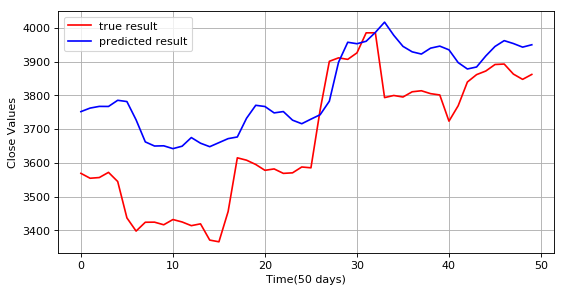

In [14]:
plt.figure(figsize=(8,4), dpi=80, facecolor='w', edgecolor='k')
plt.plot(data_test,color="r",label="true result")
plt.plot(predicted_data,color="b",label="predicted result")
plt.legend()
plt.xlabel("Time(50 days)")
plt.ylabel("Close Values")
plt.grid(True)
plt.show()

Here we have the results of our prediction. As we can see on the chart that with RNN method we don't have a good result. So let's check LSTM method, then we can compare both results.

**Keep going with LSTM method**

I will use the same train and test data

In [15]:
from sklearn.metrics import mean_absolute_error
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout,Flatten

model=Sequential()

model.add(LSTM(10,input_shape=(None,1),activation="relu"))

model.add(Dense(1))

model.compile(loss="mean_squared_error",optimizer="adam")

model.fit(x_train,y_train,epochs=100,batch_size=32)

Epoch 1/100
2527/2527 [==============================] - 5s 2ms/step - loss: 0.0273
Epoch 2/100
2527/2527 [==============================] - 4s 2ms/step - loss: 0.0080
Epoch 3/100
2527/2527 [==============================] - 4s 2ms/step - loss: 4.8358e-04
Epoch 4/100
2527/2527 [==============================] - 4s 2ms/step - loss: 4.2703e-04
Epoch 5/100
2527/2527 [==============================] - 4s 2ms/step - loss: 3.3468e-04
Epoch 6/100
2527/2527 [==============================] - 4s 2ms/step - loss: 3.2717e-04
Epoch 7/100
2527/2527 [==============================] - 4s 2ms/step - loss: 2.9219e-04
Epoch 8/100
2527/2527 [==============================] - 4s 2ms/step - loss: 2.7433e-04
Epoch 9/100
2527/2527 [==============================] - 4s 2ms/step - loss: 2.5810e-04
Epoch 10/100
2527/2527 [==============================] - 4s 2ms/step - loss: 2.4953e-04
Epoch 11/100
2527/2527 [==============================] - 4s 2ms/step - loss: 2.3934e-04
Epoch 12/100
2527/2527 [==============

Keep going with test data

In [16]:
inputs=data[len(data)-len(close_test)-timestep:]
inputs=inputs.values.reshape(-1,1)
inputs=scaler.transform(inputs)

In [17]:
x_test=[]
for i in range(timestep,inputs.shape[0]):
    x_test.append(inputs[i-timestep:i,0])
x_test=np.array(x_test)
x_test=x_test.reshape(x_test.shape[0],x_test.shape[1],1)

it's time to predict

In [18]:
predicted_data=model.predict(x_test)
predicted_data=scaler.inverse_transform(predicted_data)

In [19]:
data_test=np.array(close_test)
data_test=data_test.reshape(len(data_test),1)

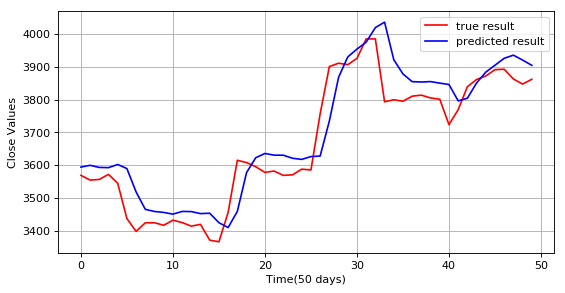

In [20]:
plt.figure(figsize=(8,4), dpi=80, facecolor='w', edgecolor='k')
plt.plot(data_test,color="r",label="true result")
plt.plot(predicted_data,color="b",label="predicted result")
plt.legend()
plt.xlabel("Time(50 days)")
plt.ylabel("Close Values")
plt.grid(True)
plt.show()

* ** Conclusion**

When we compare the both results (RNN and LSTM) we can see that we have better prediction with LSTM. 

Up to here I was trying to show the differences between RNN - LSTM and how to use these methods on time series. 

If you have any question or I have any error please write me dirctly.
